In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, classification_report
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
base_path = '/kaggle/input/playground-series-s5e3/'
df_train = pd.read_csv(os.path.join(base_path, 'train.csv'))
df_test = pd.read_csv(os.path.join(base_path, 'test.csv'))
df_submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [3]:
df_train.shape

(2190, 13)

In [4]:
df_train.drop(columns=['id', 'day'], inplace=True)
df_test.drop(columns=['id', 'day'], inplace=True)
df_train.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [5]:
df_train.isna().sum()

pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [6]:
df_test.isna().sum()

pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [7]:
df_test['winddirection'].fillna(method='backfill', inplace=True)

<ipython-input-7-8f505548d10b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['winddirection'].fillna(method='backfill', inplace=True)
<ipython-input-7-8f505548d10b>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test['winddirection'].fillna(method='backfill', inplace=True)


In [8]:
def prepare_data(train, test):

    return train, test


In [9]:
df_train, df_test = prepare_data(df_train, df_test)

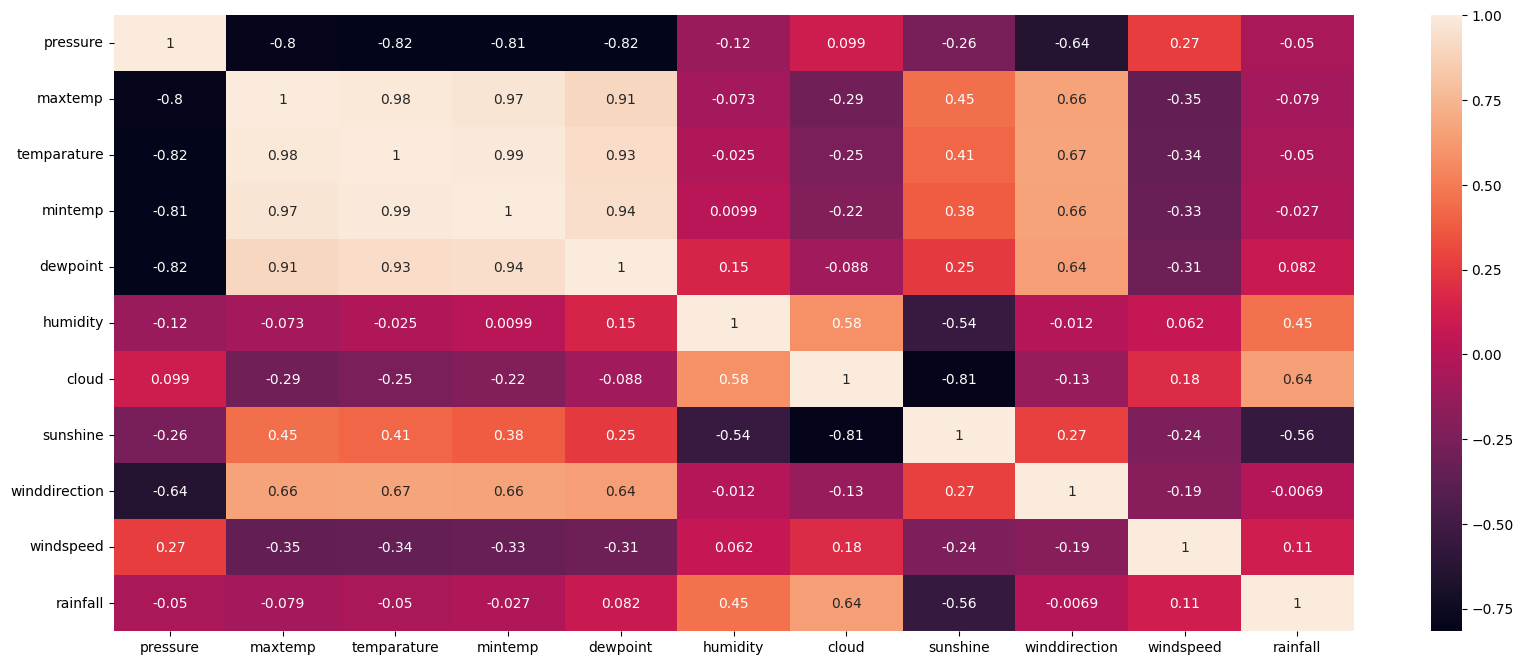

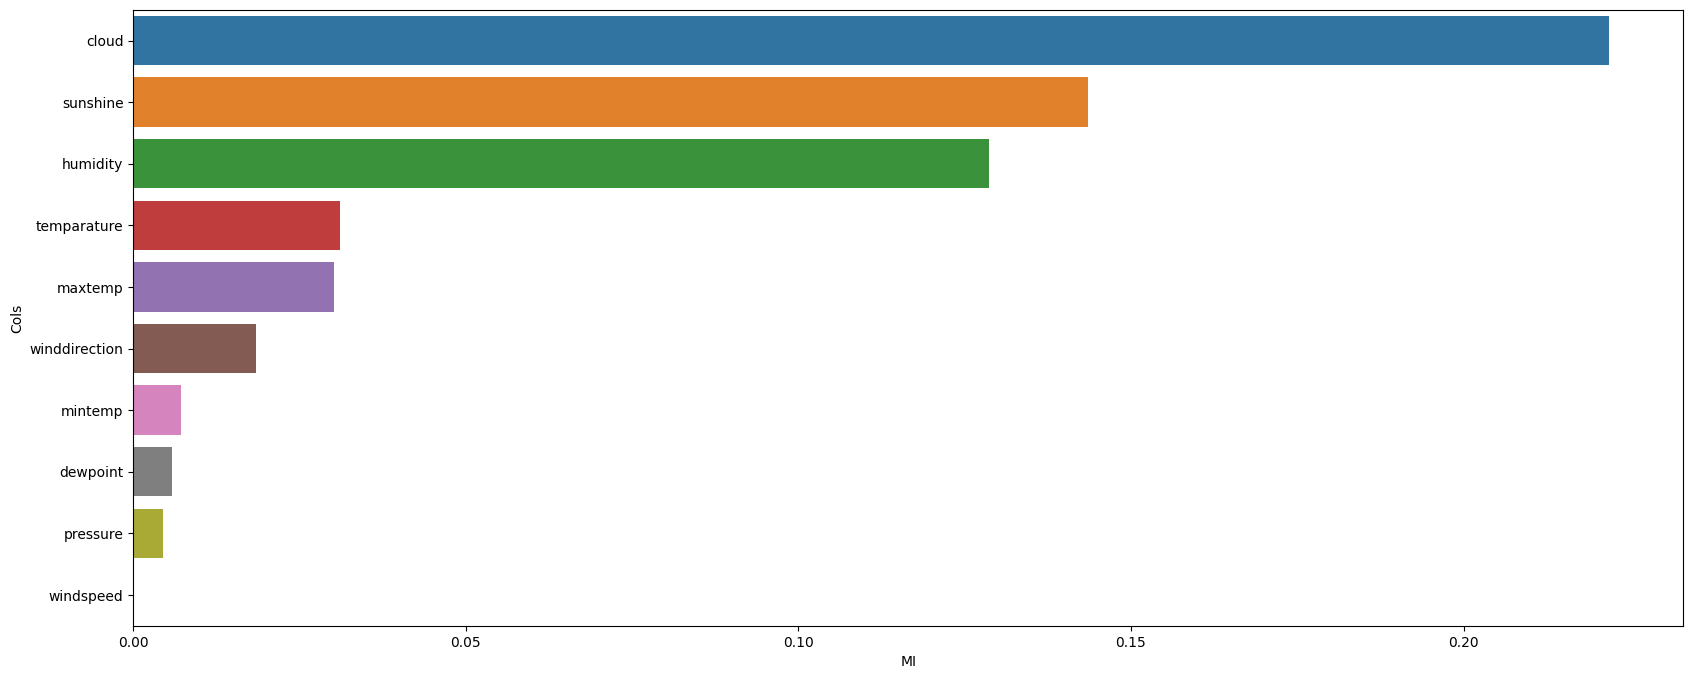

In [10]:
plt.figure(figsize=(20,8))
sns.heatmap(df_train.corr(),annot=True)
plt.show()

X = df_train.drop(columns=['rainfall'])
y = df_train['rainfall']
mi=mutual_info_regression(X,y)
mi_df=pd.DataFrame({"Cols":X.columns,'MI':mi})
mi_df.sort_values(ascending=False,inplace=True,by='MI')

plt.figure(figsize=(20,8))
sns.barplot(data=mi_df,x='MI',y='Cols')
plt.show()

In [11]:
# matrix = df_train.corr()

# # plotting correlation matrix
# plt.imshow(matrix, cmap='Blues')

# # adding colorbar
# plt.colorbar()

# # extracting variable names
# variables = []
# for i in matrix.columns:
#     variables.append(i)

# # Adding labels to the matrix
# plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
# plt.yticks(range(len(matrix)), variables)

# # Display the plot
# plt.show()

In [12]:
# matrix = df_train.corr()

# # plotting correlation matrix
# sns.heatmap(matrix, cmap="Greens", annot=True, fmt='.2f', annot_kws={"size": 6} )


In [13]:
# features = ['humidity', 'cloud', 'sunshine', 'windspeed', 'temp_diff', 'dewpoint_spread', 'cloud_sun_ratio']

In [14]:
# matrix = df_train[features].corr()

# # plotting correlation matrix
# sns.heatmap(matrix, cmap="Greens", annot=True, fmt='.2f', annot_kws={"size": 6} )


In [15]:
#features = ['pressure','maxtemp','temparature','mintemp','dewpoint','humidity', 'cloud', 'sunshine', 'winddirection','windspeed']
#features = ['humidity', 'cloud', 'sunshine', 'windspeed', 'dewpoint']
# X, y = df_train.drop(columns=['rainfall'])[features], df_train['rainfall']

X = df_train.drop('rainfall', axis=1)
y = df_train['rainfall']

In [16]:
# X = df_train.drop(columns=['rainfall','winddirection','windspeed'])
# y = df_train['rainfall']

In [17]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                   stratify=y_resampled)

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# # Define parameter grid for tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7, 9],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# # Randomized Search for Hyperparameter Tuning
# xgb_tuned = XGBClassifier(random_state=42, eval_metric='auc')
# random_search = RandomizedSearchCV(
#     xgb_tuned,
#     param_grid,
#     n_iter=50,
#     scoring='roc_auc',
#     cv=5,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)


In [21]:
# random_search.best_estimator_

In [22]:
# best_model = random_search.best_estimator_
# # y_pred_tuned = best_model.predict(X_test)
# # y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

# # roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
# # classification_report_tuned = classification_report(y_test, y_pred_tuned)
# mdl = run_model(best_model, X_train, y_train, X_test, y_test)

In [23]:
#mdl.predict_proba(X_test)[:,1]

In [24]:
def run_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    print("train score: ", model.score(X_train, y_train))
    print("test score: ", model.score(X_test, y_test))
    print("roc_auc_score: ", roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    
    scores = model.predict_proba(X_train)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return model

In [25]:
space={
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'eval_metric': 'logloss',
        'learning_rate': hp.loguniform('learning_rate', -5, -2),
        'objective': 'binary:logistic',
        'seed': 0
    }

In [26]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators = int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],
                    reg_lambda = space['reg_lambda'],
                    colsample_bytree = space['colsample_bytree'],
                    min_child_weight = space['min_child_weight'],
                    eval_metric = space['eval_metric'],
                    learning_rate = space['learning_rate'],
                    objective = space['objective'],
                    seed = space['seed'],
                    early_stopping_rounds=10
    )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [27]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.8505050505050505
SCORE:
0.6666666666666666
SCORE:
0.8242424242424242
SCORE:
0.6666666666666666
SCORE:
0.8444444444444444
SCORE:
0.8464646464646465
SCORE:
0.8505050505050505
SCORE:
0.8404040404040404
SCORE:
0.8464646464646465
SCORE:
0.8464646464646465
SCORE:
0.8444444444444444
SCORE:
0.8484848484848485
SCORE:
0.6666666666666666
SCORE:
0.8484848484848485
SCORE:
0.8464646464646465
SCORE:
0.8505050505050505
SCORE:
0.8424242424242424
SCORE:
0.8484848484848485
SCORE:
0.8424242424242424
SCORE:
0.8464646464646465
SCORE:
0.8464646464646465
SCORE:
0.8363636363636363
SCORE:
0.8505050505050505
SCORE:
0.8484848484848485
SCORE:
0.8505050505050505
SCORE:
0.8363636363636363
SCORE:
0.8484848484848485
SCORE:
0.8505050505050505
SCORE:
0.8424242424242424
SCORE:
0.8444444444444444
SCORE:
0.8484848484848485
SCORE:
0.8323232323232324
SCORE:
0.6666666666666666
SCORE:
0.8484848484848485
SCORE:
0.8484848484848485
SCORE:
0.8505050505050505
SCORE:
0.8444444444444444
SCORE:
0.8464646464646465
SCORE:
0.848

train score:  0.8505050505050505
test score:  0.8525252525252526
roc_auc_score:  0.8926015840220385


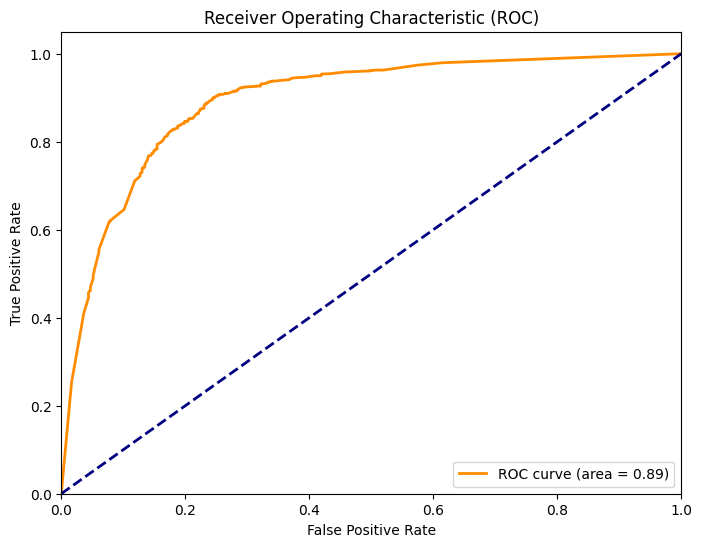

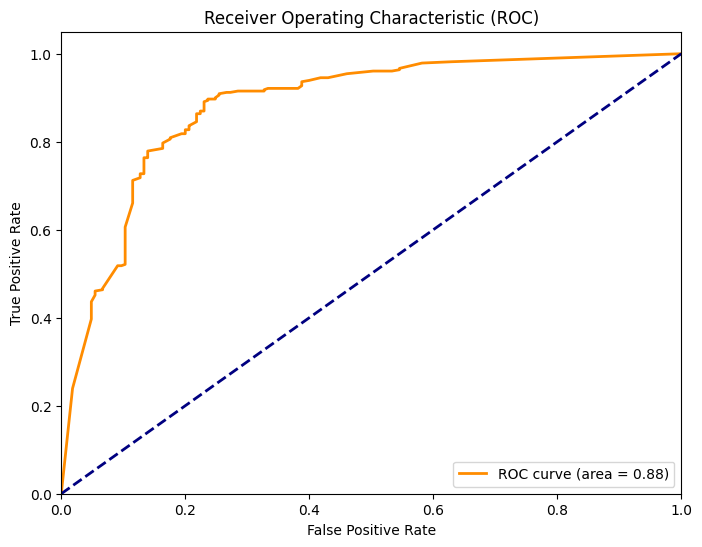

In [28]:
clf_xgbost = xgb.XGBClassifier(n_estimators = int(best_hyperparams['n_estimators']), 
                    max_depth = int(best_hyperparams['max_depth']), 
                    gamma = best_hyperparams['gamma'],
                    reg_alpha = best_hyperparams['reg_alpha'],
                    reg_lambda = best_hyperparams['reg_lambda'],
                    colsample_bytree = best_hyperparams['colsample_bytree'],
                    min_child_weight = best_hyperparams['min_child_weight'],
                    eval_metric = 'auc',
                    learning_rate = best_hyperparams['learning_rate'],
                    objective = 'binary:logistic')

clf_xgboost = run_model(clf_xgbost, X_train, y_train, X_test, y_test)

In [29]:
ypred = clf_xgboost.predict_proba(scaler.transform(df_test))[:, 1]
df_submission['rainfall'] = ypred
df_submission.to_csv("submission.csv", index=False)

In [30]:
# ypred

In [31]:
# model = LogisticRegression()
# param_grid = [    
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100, 1000,2500, 5000]
#     }
# ]

In [32]:
# model = LogisticRegression()
# param_grid = [    
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100, 1000,2500, 5000]
#     }
# ]
# clf = RandomizedSearchCV(model, param_grid, n_iter=50, cv=5, n_jobs=-1)
# #clf = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
# best_clf = clf.fit(X_train, y_train)

In [33]:
# clf_log = LogisticRegression(**best_clf.best_params_)
# clf_log = run_model(clf_log, X_train, y_train, X_test, y_test)

In [34]:
# ypred = clf_log.predict_proba(scaler.transform(df_test[features]))
# df_submission['rainfall'] = ypred[:, 1]
# df_submission.to_csv("submission.csv", index=False)

In [35]:
# def run_svc(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)

#     print("train score: ", round(model.score(X_train, y_train), 4))
#     print("roc_auc_score_train: ", round(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),4))
#     print("test score: ", round(model.score(X_test, y_test), 4))
#     print("roc_auc_score_train: ", round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),4))


In [36]:
# param_grid = {
#     'degree': [0, 1, 6],
#     'C': [0.1, 1, 10],
#     'gamma': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
# }

# for i in param_grid['degree']:
#     print(f"degree: {i}")
#     clf_svm = svm.SVC(probability=True, degree=i)
#     run_svc(clf_svm, X_train, y_train, X_test, y_test)

# for i in param_grid['C']:
#     print(f"C: {i}")
#     clf_svm = svm.SVC(probability=True, C=i)
#     run_svc(clf_svm, X_train, y_train, X_test, y_test)

# for i in param_grid['gamma']:
#     print(f"gamma: {i}")
#     clf_svm = svm.SVC(probability=True, gamma=i)
#     run_svc(clf_svm, X_train, y_train, X_test, y_test)

# for i in param_grid['kernel']:
#     print(f"kernel: {i}")
#     clf_svm = svm.SVC(probability=True, kernel=i)
#     run_svc(clf_svm, X_train, y_train, X_test, y_test)




In [37]:
# clf_svm = svm.SVC(probability=True, kernel='linear', gamma=0.1, C=0.1)
# clf_svm = run_model(clf_svm, X_train, y_train, X_test, y_test)

In [38]:
# param_grid = {
#     'degree': [0, 1, 6],
#     'C': [0.1, 1, 10],
#     'gamma': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
# }




#gridSearch = GridSearchCV(estimator=model,param_grid={'degree':degreeG,'kernel':kernelsG,'C':cSetG,'gamma':gammaG},cv=5)
#randomSearch = RandomizedSearchCV(model, param_grid, n_iter=50, cv=5, n_jobs=-1)

#clf_svm = svm.SVC(probability=True, kernel='linear')
# clf_svm = svm.SVC(probability=True, gamma=0.2)
# clf_svm = run_model(clf_svm, X_train, y_train, X_test, y_test)

In [39]:
# clf_tree = DecisionTreeClassifier(max_features="sqrt", max_depth=4)
# clf_tree = run_model(clf_tree, X_train, y_train, X_test, y_test)

In [40]:
# clf_rfc = RandomForestClassifier(n_estimators=600, max_features="sqrt", max_depth=4)
# clf_rfc = run_model(clf_rfc, X_train, y_train, X_test, y_test)

In [41]:
# param_distributions = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10]
# }
# random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions, n_iter=50, cv=5, n_jobs=-1)
# random_search.fit(X_train, y_train)

In [42]:
#dir(random_search)
#random_search.best_params_

In [43]:
# clf_rfc = RandomForestClassifier(**random_search.best_params_)
# clf_rfc = run_model(clf_rfc, X_train, y_train, X_test, y_test)

In [44]:
#ypred = clf_rfc.predict_proba(scaler.transform(df_test[features]))

In [45]:
# xgb_clf = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc')

# # Define parameter grid for RandomizedSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [3, 4, 5, 6, 7, 8],
#     'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4],
#     'min_child_weight': [1, 2, 3, 4, 5]
# }

# # Run RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=xgb_clf, 
#     param_distributions=param_grid, 
#     n_iter=20,  # Number of random combinations to try
#     scoring='roc_auc', 
#     cv=5, 
#     verbose=1, 
#     random_state=42, 
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)
# # Best parameters
# print("Best Parameters:", random_search.best_params_)

In [46]:
# clf_xgboost = run_model(xgb.XGBClassifier(**random_search.best_params_), X_train, y_train, X_test, y_test)

In [47]:
#list(hp.quniform("max_depth", 3, 18, 1))

In [48]:
# space={
#         'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
#         'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'eval_metric': 'logloss',
#         'learning_rate': hp.loguniform('learning_rate', -5, -2),
#         'objective': 'binary:logistic',
#         'seed': 0
#     }

In [49]:
# def objective(space):
#     clf=xgb.XGBClassifier(
#                     n_estimators = int(space['n_estimators']), 
#                     max_depth = int(space['max_depth']), 
#                     gamma = space['gamma'],
#                     reg_alpha = space['reg_alpha'],
#                     reg_lambda = space['reg_lambda'],
#                     colsample_bytree = space['colsample_bytree'],
#                     min_child_weight = space['min_child_weight'],
#                     eval_metric = space['eval_metric'],
#                     learning_rate = space['learning_rate'],
#                     objective = space['objective'],
#                     seed = space['seed'],
#                     early_stopping_rounds=10
#     )
    
#     evaluation = [( X_train, y_train), ( X_test, y_test)]
    
#     clf.fit(X_train, y_train,
#             eval_set=evaluation, verbose=False)
    

#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }

In [50]:
# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

In [51]:
# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)

In [52]:
# clf_xgbost = xgb.XGBClassifier(n_estimators = int(best_hyperparams['n_estimators']), 
#                     max_depth = int(best_hyperparams['max_depth']), 
#                     gamma = best_hyperparams['gamma'],
#                     reg_alpha = best_hyperparams['reg_alpha'],
#                     reg_lambda = best_hyperparams['reg_lambda'],
#                     colsample_bytree = best_hyperparams['colsample_bytree'],
#                     min_child_weight = best_hyperparams['min_child_weight'],
#                     eval_metric = 'auc',
#                     learning_rate = best_hyperparams['learning_rate'],
#                     objective = 'binary:logistic')

# clf_xgboost = run_model(clf_xgbost, X_train, y_train, X_test, y_test)

In [53]:
# ypred = clf_xgboost.predict_proba(scaler.transform(df_test[features]))
# df_submission['rainfall'] = ypred[:, 1]
# df_submission.to_csv("submission.csv", index=False)